[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/dbsn-import/blob/main/townhalls_indicepa.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/dbsn-import/blob/main/townhalls_indicepa.ipynb)

# Finding missing town halls in Italy

### Configuration

In [200]:
search_area_id = 3600365331 # Italia
#search_area_id = 3600042611 # Emilia-Romagna
# ID calculated with https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_element_id

In [201]:
province_json_file_path = f"./provinces_{search_area_id}.4326.geojson"
municipality_json_file_path = f"./municipalities_{search_area_id}.4326.geojson"
townhall_json_file_path = f"./townhalls_{search_area_id}.4326.geojson"
without_townhall_json_file_path = f"./without_townhall_{search_area_id}.4326.geojson"
indicepa_csv_file_path = f"./indicepa.csv"
out_csv_file_path = f"./indicepa_merged_{search_area_id}.csv"
out_json_file_path = f"./indicepa_merged_{search_area_id}.4326.geojson"
to_geocode_csv_file_path = f"./indicepa_to_geocode_{search_area_id}.csv"
geocoded_csv_file_path = f"./indicepa_geocoded_{search_area_id}.csv"
geocoded_json_file_path = f"./indicepa_geocoded_{search_area_id}.4326.geojson"
untagged_json_file_path = f"./untagged_{search_area_id}.4326.geojson"
untagged_missing_json_file_path = f"./untagged_missing_{search_area_id}.4326.geojson"

### Setup

In [202]:
#%pip install geopandas contextily pyproj rtree shapely

In [203]:
from pandas import read_csv, merge
from geopandas import GeoDataFrame, read_file, points_from_xy
from shapely.geometry import shape, Point, MultiPolygon
from shapely.ops import polygonize
from urllib.request import urlopen, urlretrieve
from urllib.error import HTTPError
from urllib.parse import quote_plus
from os.path import exists
import contextily as cx
import json
from os import system

### Download municipalities and existing town halls from Overpass

In [204]:
province_overpass_query=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
relation["boundary"="administrative"]["admin_level"="6"]["ISO3166-2"!="FR-74"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [205]:
municipality_overpass_query=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
relation["boundary"="administrative"]["admin_level"="8"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [206]:
townhall_overpass_query=f"""
[out:json][timeout:90];
area({search_area_id})->.searchArea;
nwr["amenity"="townhall"](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [207]:
def fetchOverpassGeoDataFrame(overpass_query, geometry_transform=shape):
    url = "https://overpass-api.de/api/interpreter?data="+quote_plus(overpass_query)
    try:
        with urlopen(url) as response:
            data = response.read()
            encoding = response.info().get_content_charset('utf-8')
            json_content = data.decode(encoding)
        if "Query timed out" in json_content:
            raise Exception("Query timed out")
        #print(json_content)
        json_object = json.loads(json_content)
        #print(json_object['elements'][0] if json_object['elements'] else "No elments")
        elements = [{
            "id": element["id"],
            "osm_id": element["tags"]["_osm_id"],
            "osm_type": element["tags"]["_osm_type"],
            "osm_url": 'https://www.openstreetmap.org/'+element["tags"]["_osm_type"]+'/'+element["tags"]["_osm_id"],
            "name": element["tags"]["name"] if "name" in element["tags"] else None,
            "geometry": geometry_transform(element['geometry'])
        } for element in json_object['elements']]
        #print(elements[0])
        # OSM uses WGS 84: https://wiki.openstreetmap.org/wiki/Converting_to_WGS84
        crs = 'EPSG:4326' # Use the SRID for WGS 84 - https://epsg.io/4326
        gdf = GeoDataFrame(elements, crs=crs)
    except HTTPError as err:
        print("Failed downloading data from Overpass, retry later")
        raise err
    except json.JSONDecodeError as err:
        print("Failed interpreting JSON data from Overpass")
        raise err
    return gdf

In [208]:
def readOrFetchOverpassGeoDataFrame(file_path, overpass_query, geometry_transform=shape):
    if exists(file_path):
        gdf = read_file(file_path, driver='GeoJSON')
    else:
        gdf = fetchOverpassGeoDataFrame(overpass_query, geometry_transform)
        gdf.to_file(file_path, driver='GeoJSON')
    return gdf

In [209]:
# Convert Overpass geometries into MultiPolygons - https://stackoverflow.com/a/72677231/2347196
convert_geom_to_multipolygon = lambda x: MultiPolygon(polygonize(shape(x)))

In [210]:
province_gdf = readOrFetchOverpassGeoDataFrame(province_json_file_path, province_overpass_query, convert_geom_to_multipolygon)
province_gdf.count()

id          109
osm_id      109
osm_type    109
osm_url     109
name        109
geometry    109
dtype: int64

In [211]:
province_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,39151,relation,https://www.openstreetmap.org/relation/39151,Agrigento,"MULTIPOLYGON (((13.98219 37.19312, 13.98220 37..."
1,2,39979,relation,https://www.openstreetmap.org/relation/39979,Nuoro,"MULTIPOLYGON (((9.62535 40.25649, 9.62514 40.2..."
2,3,40021,relation,https://www.openstreetmap.org/relation/40021,Aristanis/Oristano,"MULTIPOLYGON (((8.38245 40.33860, 8.38324 40.3..."
3,4,276369,relation,https://www.openstreetmap.org/relation/276369,Cagliari,"MULTIPOLYGON (((9.16386 39.83254, 9.16450 39.8..."
4,5,12998776,relation,https://www.openstreetmap.org/relation/12998776,Sulcis Iglesiente,"MULTIPOLYGON (((8.37422 39.02318, 8.37403 39.0..."


In [212]:
municipality_gdf = readOrFetchOverpassGeoDataFrame(municipality_json_file_path, municipality_overpass_query, convert_geom_to_multipolygon)
municipality_gdf.count()

id          7903
osm_id      7903
osm_type    7903
osm_url     7903
name        7903
geometry    7903
dtype: int64

In [213]:
municipality_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,39150,relation,https://www.openstreetmap.org/relation/39150,Lampedusa e Linosa,"MULTIPOLYGON (((12.87805 35.85517, 12.87809 35..."
1,2,39777,relation,https://www.openstreetmap.org/relation/39777,Santu Antiogu/Sant'Antioco,"MULTIPOLYGON (((8.38404 39.00591, 8.38379 39.0..."
2,3,39809,relation,https://www.openstreetmap.org/relation/39809,Câdesédda/Calasetta,"MULTIPOLYGON (((8.37490 39.10915, 8.37532 39.1..."
3,4,39853,relation,https://www.openstreetmap.org/relation/39853,Igrèsias/Iglesias,"MULTIPOLYGON (((8.43347 39.30784, 8.43347 39.3..."
4,5,39915,relation,https://www.openstreetmap.org/relation/39915,Bugerru/Buggerru,"MULTIPOLYGON (((8.41075 39.44130, 8.41059 39.4..."


In [214]:
townhall_gdf = readOrFetchOverpassGeoDataFrame(townhall_json_file_path, townhall_overpass_query)
townhall_gdf.count()

id          7212
osm_id      7212
osm_type    7212
osm_url     7212
name        5633
geometry    7212
dtype: int64

In [215]:
townhall_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,4492704609,node,https://www.openstreetmap.org/node/4492704609,Comune di Carloforte,POINT (8.30562 39.14578)
1,2,2440099045,node,https://www.openstreetmap.org/node/2440099045,None,POINT (8.37907 39.20365)
2,3,1853454108,node,https://www.openstreetmap.org/node/1853454108,Comune di Teulada,POINT (8.77381 38.96790)
3,4,5358907076,node,https://www.openstreetmap.org/node/5358907076,Comune di Sant'Antioco,POINT (8.45543 39.06645)
4,5,2126087185,node,https://www.openstreetmap.org/node/2126087185,Comune di San Giovanni Suergiu,POINT (8.52207 39.11028)


In [277]:
from matplotlib import pyplot as plt
def show_map(geo_df:GeoDataFrame, background_gdf:GeoDataFrame=None, color_column:str=None, cmap:str=None):
    df_wm = geo_df.to_crs(epsg=3857)
    figsize=(20,10)
    fig,ax = plt.subplots(1, 1, figsize=figsize)
    legend = False
    
    if background_gdf is not None:
        background_df_wm = background_gdf.to_crs(epsg=3857)
        ax = background_df_wm.plot(ax=ax, figsize=figsize, alpha=0.3, edgecolor='k')
    
    if color_column is not None:
        legend = True
    
    ax = df_wm.plot(ax=ax, figsize=figsize, edgecolor='k', column=color_column, cmap=cmap, legend=legend)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)

Map of municipalities available on OSM:

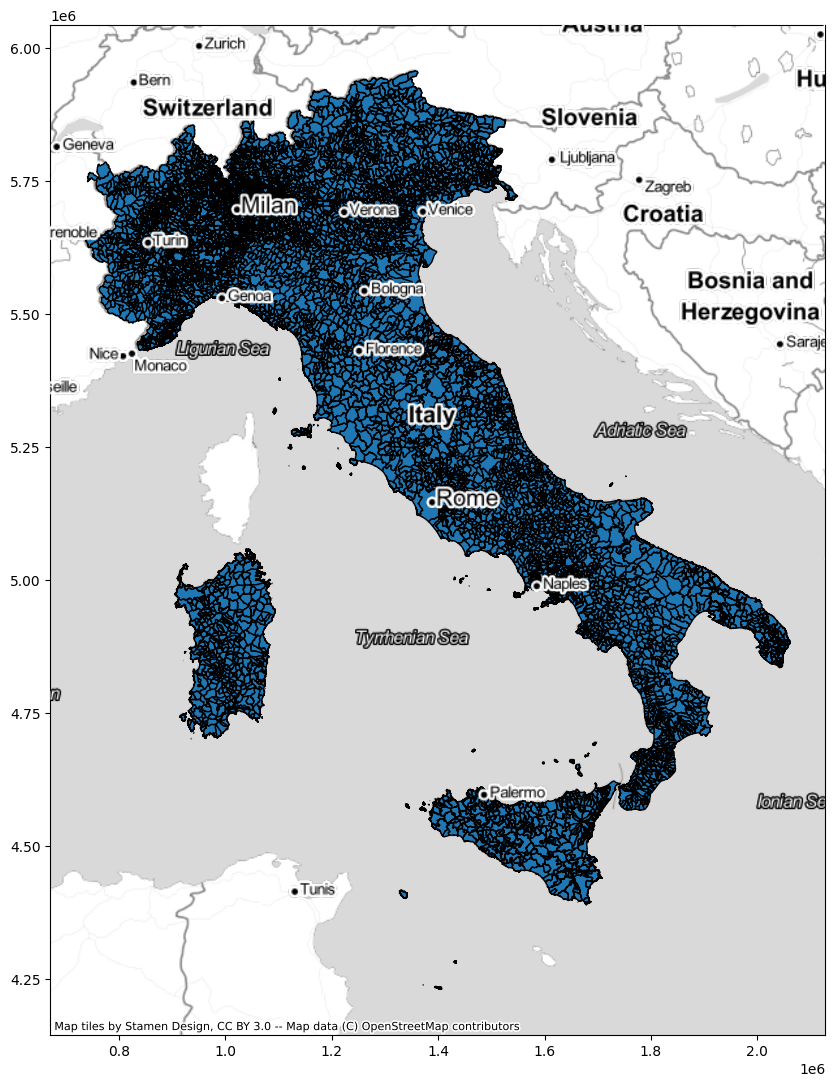

In [274]:
show_map(municipality_gdf)

Map of town halls available on OSM:

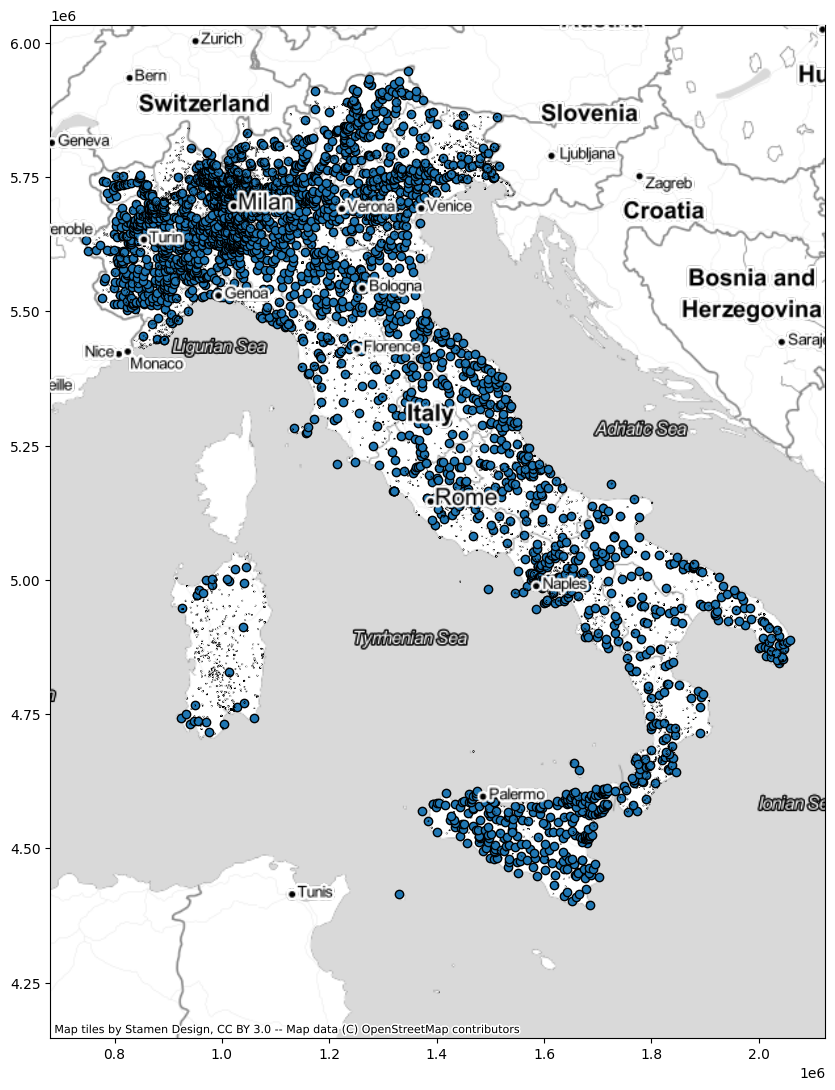

In [260]:
show_map(townhall_gdf)
#show_map(townhall_gdf, municipality_gdf)
#municipality_gdf.explore()
#townhall_gdf.explore()

### Find municipalities without town halls

In [219]:
with_townhall_gdf = townhall_gdf.sjoin(
        municipality_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
with_townhall_gdf.count()

id_hall          7218
osm_id_hall      7218
osm_type_hall    7218
osm_url_hall     7218
name_hall        5638
geometry         7218
index_town       7218
id_town          7218
osm_id_town      7218
osm_type_town    7218
osm_url_town     7218
name_town        7218
dtype: int64

In [220]:
without_townhall_gdf = municipality_gdf[ # Anti-join
        ~municipality_gdf["id"].isin(with_townhall_gdf["id_town"])
    ]
without_townhall_gdf.to_file(without_townhall_json_file_path, driver="GeoJSON")
without_townhall_gdf.count()

id          1320
osm_id      1320
osm_type    1320
osm_url     1320
name        1320
geometry    1320
dtype: int64

In [221]:
without_townhall_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
27,28,39855,relation,https://www.openstreetmap.org/relation/39855,Bidda Matzràxia/Villamassargia,"MULTIPOLYGON (((8.73100 39.28096, 8.73147 39.2..."
44,45,39803,relation,https://www.openstreetmap.org/relation/39803,Sa Baronia/Villaperuccio,"MULTIPOLYGON (((8.61680 39.12812, 8.61717 39.1..."
185,186,12338682,relation,https://www.openstreetmap.org/relation/12338682,Misiliscemi,"MULTIPOLYGON (((12.49852 37.96577, 12.50396 37..."
426,427,40827,relation,https://www.openstreetmap.org/relation/40827,Caragnani/Calangianus,"MULTIPOLYGON (((9.30121 40.84693, 9.30056 40.8..."
453,454,40950,relation,https://www.openstreetmap.org/relation/40950,Sant'Antoni di Gaddura/Sant'Antonio di Gallura,"MULTIPOLYGON (((9.31750 40.92267, 9.31720 40.9..."


Map of municipalities without town hall:

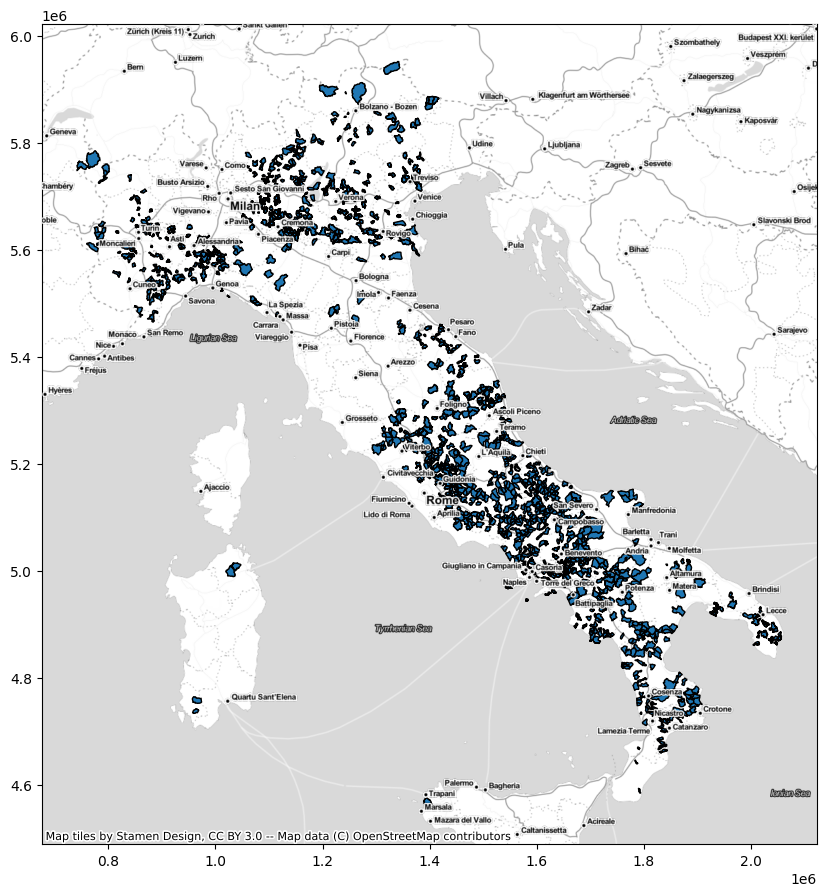

In [275]:
show_map(without_townhall_gdf)
#without_townhall_gdf.explore()

### Calculate statistics for each province

In [223]:
pro_mun_df = province_gdf[["id","geometry"]].sjoin(
        municipality_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_municipalities"] = pro_mun_df.groupby(pro_mun_df.index).count()["index_mun"]

In [224]:
prov_wt_df = province_gdf[["id","geometry"]].sjoin(
        without_townhall_gdf[["geometry"]],
        how="left",
        predicate="contains",
        lsuffix="pro",
        rsuffix="mun"
    )
province_gdf["num_without_townhall"] = prov_wt_df.groupby(prov_wt_df.index).count()["index_mun"]

<AxesSubplot: >

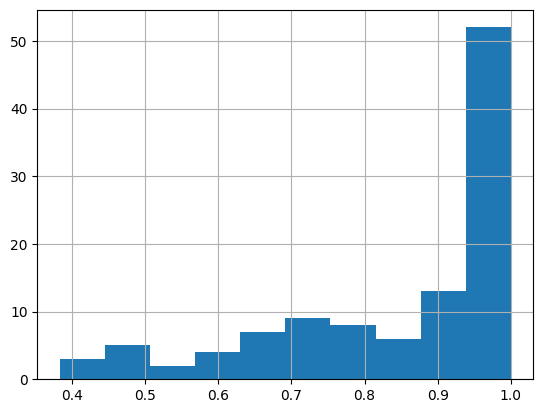

In [268]:
province_gdf["availability"] = 1 - (province_gdf["num_without_townhall"] / province_gdf["num_municipalities"])
province_gdf["availability"].hist()

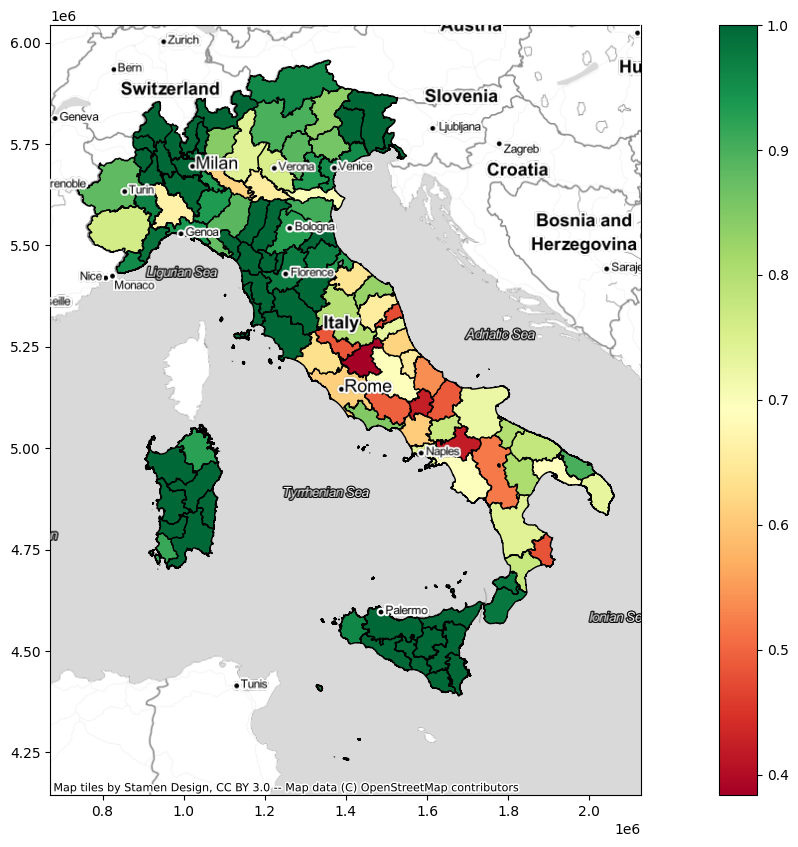

In [278]:
show_map(province_gdf, None, "availability", "RdYlGn")

### Find OSM untagged building named as town halls

In [227]:
untagged_overpass_query=f"""
[out:json][timeout:300];
area({search_area_id})->.searchArea;
nwr["building"]["amenity"!="townhall"]["name"~"^(\s|palazzo|del|nuovo|comune|-)*municipio",i](area.searchArea);
convert item ::=::,::geom=geom(),_osm_type=type(),_osm_id=id();
out geom;
"""

In [228]:
untagged_gdf = readOrFetchOverpassGeoDataFrame(untagged_json_file_path, untagged_overpass_query)
untagged_gdf.count()

id          30
osm_id      30
osm_type    30
osm_url     30
name        30
geometry    30
dtype: int64

In [229]:
untagged_gdf.head()

,id,osm_id,osm_type,osm_url,name,geometry
0,1,277834707,way,https://www.openstreetmap.org/way/277834707,Municipio di Monserrato,"LINESTRING (9.14363 39.25416, 9.14336 39.25394..."
1,2,933053288,way,https://www.openstreetmap.org/way/933053288,Municipio,"LINESTRING (13.09184 37.95253, 13.09212 37.952..."
2,3,332108931,way,https://www.openstreetmap.org/way/332108931,Municipio Roma V - Aula consigliare,"LINESTRING (12.54262 41.88052, 12.54278 41.880..."
3,4,60145522,way,https://www.openstreetmap.org/way/60145522,Municipio,"LINESTRING (12.95500 41.58178, 12.95523 41.581..."
4,5,42089778,way,https://www.openstreetmap.org/way/42089778,Municipio Frosinone,"LINESTRING (13.35066 41.63963, 13.35074 41.639..."


In [230]:
untagged_missing_gdf = untagged_gdf.sjoin(
        without_townhall_gdf,
        how="inner",
        predicate="within",
        lsuffix="hall",
        rsuffix="town"
    )
untagged_missing_gdf.count()

id_hall          2
osm_id_hall      2
osm_type_hall    2
osm_url_hall     2
name_hall        2
geometry         2
index_town       2
id_town          2
osm_id_town      2
osm_type_town    2
osm_url_town     2
name_town        2
dtype: int64

In [231]:
untagged_missing_gdf.head()

,id_hall,osm_id_hall,osm_type_hall,osm_url_hall,name_hall,geometry,index_town,id_town,osm_id_town,osm_type_town,osm_url_town,name_town
4,5,42089778,way,https://www.openstreetmap.org/way/42089778,Municipio Frosinone,"LINESTRING (13.35066 41.63963, 13.35074 41.639...",702,703,41419,relation,https://www.openstreetmap.org/relation/41419,Frosinone
10,11,672589063,way,https://www.openstreetmap.org/way/672589063,Municipio di Atella di Napoli (1928-46),"LINESTRING (14.26055 40.96097, 14.26056 40.961...",1834,1835,40939,relation,https://www.openstreetmap.org/relation/40939,Sant'Arpino


In [232]:
untagged_missing_gdf.to_file(untagged_missing_json_file_path, driver='GeoJSON')

In [233]:
#show_map(untagged_missing_gdf)
untagged_missing_gdf.explore()

### Find possible town halls from official Open Data

---
**!! IMPORTANT NOTE !!**

This data is licensed under CC-BY-4.0 which is not compatible for import in OpenStreetMap so it's useful for explorative purposes only.

---

#### Download official open data on town halls

In [234]:
def download_file_if_not_exists(file_path, url):
    if not exists(file_path):
        try: 
            urlretrieve(url, file_path)
        except HTTPError as err:
            print("Failed downloading data from Overpass, retry later")
            raise err

In [235]:
# https://indicepa.gov.it/ipa-dati/dataset/enti
indicepa_url = "https://indicepa.gov.it/ipa-dati/datastore/dump/d09adf99-dc10-4349-8c53-27b1e5aa97b6?bom=True"
download_file_if_not_exists(indicepa_csv_file_path, indicepa_url)

In [236]:
enti_df = read_csv(indicepa_csv_file_path, dtype={
    "Codice_fiscale_ente": 'str',
    "CAP": 'str'
}).query('Codice_Categoria=="L6" & Codice_ateco=="84.11.10"')
enti_df.count()


_id                        7906
Codice_IPA                 7906
Denominazione_ente         7906
Codice_fiscale_ente        7906
Tipologia                  7906
Codice_Categoria           7906
Codice_natura              7906
Codice_ateco               7906
Ente_in_liquidazione         25
Codice_MIUR                   0
Codice_ISTAT               7905
Acronimo                    346
Nome_responsabile          7906
Cognome_responsabile       7906
Titolo_responsabile        7906
Codice_comune_ISTAT        7906
Codice_catastale_comune    7906
CAP                        7906
Indirizzo                  7906
Mail1                      7906
Tipo_Mail1                 7906
Mail2                      6082
Tipo_Mail2                 6082
Mail3                      1947
Tipo_Mail3                 1947
Mail4                       976
Tipo_Mail4                  976
Mail5                       616
Tipo_Mail5                  616
Sito_istituzionale         7883
Url_facebook               1131
Url_link

In [237]:
enti_df.head()

,_id,Codice_IPA,Denominazione_ente,Codice_fiscale_ente,Tipologia,Codice_Categoria,Codice_natura,Codice_ateco,Ente_in_liquidazione,Codice_MIUR,...,Mail4,Tipo_Mail4,Mail5,Tipo_Mail5,Sito_istituzionale,Url_facebook,Url_linkedin,Url_twitter,Url_youtube,Data_aggiornamento
42,43,3PS17TYB,comune di misiliscemi,93085580814,Pubbliche Amministrazioni,L6,2430.0,84.11.10,NaN,NaN,...,NaN,NaN,NaN,NaN,www.comune.misiliscemi.tp.it,NaN,NaN,NaN,NaN,2022-07-18
133,134,A690_bpe,Comune di Bascape',00414580183,Pubbliche Amministrazioni,L6,2430.0,84.11.10,NaN,NaN,...,NaN,NaN,NaN,NaN,www.comune.bascape.pv.it,NaN,NaN,NaN,NaN,2022-03-09
1362,1363,B432,Comune di Calto,00197650294,Pubbliche Amministrazioni,L6,2430.0,84.11.10,NaN,NaN,...,NaN,NaN,NaN,NaN,www.comune.calto.ro.it,NaN,NaN,NaN,NaN,2022-05-17
1394,1395,c_0319,Comune di Dolcedo,00246190086,Pubbliche Amministrazioni,L6,2430.0,84.11.10,NaN,NaN,...,NaN,NaN,NaN,NaN,www.comune.dolcedo.im.it,NaN,NaN,NaN,NaN,2020-09-17
1395,1396,c_067039,Comune di Sant'Omero,82002660676,Pubbliche Amministrazioni,L6,2430.0,84.11.10,NaN,NaN,...,NaN,NaN,NaN,NaN,www.comune.santomero.te.it,NaN,NaN,NaN,NaN,2018-01-11


In [238]:
normalizeName = lambda x: x.str.lower().str.replace(" *- *"," ",regex=True).str.replace("è|é","e'",regex=True).str.replace("comune di ", "")
merged_df = merge(
    without_townhall_gdf,
    enti_df[['CAP','Indirizzo']],
    how = "left", # left / outer / right
    left_on = normalizeName(without_townhall_gdf["name"]),
    right_on = normalizeName(enti_df["Denominazione_ente"])
)
merged_df.count()

key_0        1321
id           1321
osm_id       1321
osm_type     1321
osm_url      1321
name         1321
geometry     1321
CAP          1289
Indirizzo    1289
dtype: int64

In [239]:
merged_df.head()

,key_0,id,osm_id,osm_type,osm_url,name,geometry,CAP,Indirizzo
0,bidda matzràxia/villamassargia,28,39855,relation,https://www.openstreetmap.org/relation/39855,Bidda Matzràxia/Villamassargia,"MULTIPOLYGON (((8.73100 39.28096, 8.73147 39.2...",NaN,NaN
1,sa baronia/villaperuccio,45,39803,relation,https://www.openstreetmap.org/relation/39803,Sa Baronia/Villaperuccio,"MULTIPOLYGON (((8.61680 39.12812, 8.61717 39.1...",NaN,NaN
2,misiliscemi,186,12338682,relation,https://www.openstreetmap.org/relation/12338682,Misiliscemi,"MULTIPOLYGON (((12.49852 37.96577, 12.50396 37...",91100,"Piazza Municipio, 1"
3,caragnani/calangianus,427,40827,relation,https://www.openstreetmap.org/relation/40827,Caragnani/Calangianus,"MULTIPOLYGON (((9.30121 40.84693, 9.30056 40.8...",NaN,NaN
4,sant'antoni di gaddura/sant'antonio di gallura,454,40950,relation,https://www.openstreetmap.org/relation/40950,Sant'Antoni di Gaddura/Sant'Antonio di Gallura,"MULTIPOLYGON (((9.31750 40.92267, 9.31720 40.9...",NaN,NaN


In [240]:
merged_df.to_file(out_json_file_path, driver="GeoJSON")

In [241]:
merged_df.drop(columns=["key_0","geometry"]).to_csv(out_csv_file_path)

#### Geocode likely town hall locations

In [242]:
to_geocode_df = merged_df[merged_df["Indirizzo"].notna()]
to_geocode_df[["min_lng","min_lat","max_lng","max_lat"]] = to_geocode_df["geometry"].bounds
to_geocode_df["Indirizzo"] = to_geocode_df["Indirizzo"].str.replace("'"," ") # https://github.com/veltman/csvgeocode/issues/18
to_geocode_df = to_geocode_df.drop(columns=["key_0","geometry"])
to_geocode_df.count()

/home/daniele/.miniconda3/envs/osm/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/daniele/.miniconda3/envs/osm/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/daniele/.miniconda3/envs/osm/lib/python3.9/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

id           1289
osm_id       1289
osm_type     1289
osm_url      1289
name         1289
CAP          1289
Indirizzo    1289
min_lng      1289
min_lat      1289
max_lng      1289
max_lat      1289
dtype: int64

In [243]:
to_geocode_df.head()

,id,osm_id,osm_type,osm_url,name,CAP,Indirizzo,min_lng,min_lat,max_lng,max_lat
2,186,12338682,relation,https://www.openstreetmap.org/relation/12338682,Misiliscemi,91100,"Piazza Municipio, 1",12.479602,37.856679,12.616981,37.971080
5,466,41316,relation,https://www.openstreetmap.org/relation/41316,Sezze,04018,"V. A. Diaz, 1",12.977018,41.426804,13.120824,41.560920
6,467,41366,relation,https://www.openstreetmap.org/relation/41366,Giuliano di Roma,03020,"B.go Vittorio Emanuele, 22",13.199457,41.508310,13.305812,41.584983
7,473,1768911,relation,https://www.openstreetmap.org/relation/1768911,Bassiano,04010,Via Aldo Manuzio 117,12.982963,41.510383,13.080179,41.581441
8,481,41309,relation,https://www.openstreetmap.org/relation/41309,Roccasecca dei Volsci,04010,Piazza Umberto I,13.192492,41.432561,13.265563,41.493344


In [244]:
to_geocode_df.to_csv(to_geocode_csv_file_path)

In [245]:
# https://github.com/veltman/csvgeocode
#system('npm install -g csvgeocode')

In [246]:
if exists(geocoded_csv_file_path):
    print("SKIPPING geocoding")
else:
    print("Geocoding...")
    url_template = 'http://nominatim.openstreetmap.org/search?format=json&viewvbox={{min_lng}},{{min_lat}},{{max_lng}},{{max_lat}}&q={{Indirizzo}},{{CAP}},{{name}}'
    #url_template = 'http://nominatim.openstreetmap.org/search?format=json&viewvbox={{min_lng}},{{min_lat}},{{max_lng}},{{max_lat}}&postalcode={{CAP}}&street={{Indirizzo}}&city={{name}}'
    system(f"csvgeocode '{to_geocode_csv_file_path}' '{geocoded_csv_file_path}' --handler osm --delay 1000 --verbose --url '{url_template}'")

SKIPPING geocoding


#### Convert likey townhall locations to GeoJSON

In [247]:
geocoded_df = read_csv(geocoded_csv_file_path)
geocoded_df.count()

Unnamed: 0    1437
id            1437
osm_id        1437
osm_type      1437
osm_url       1437
name          1437
CAP           1437
Indirizzo     1437
min_lng       1437
min_lat       1437
max_lng       1437
max_lat       1437
lat            546
lng            546
dtype: int64

In [248]:
crs = 'EPSG:4326' # Use the SRID for WGS 84 - https://epsg.io/4326
geocoded_df = geocoded_df[geocoded_df["lng"].notna()]
geocoded_df["geometry"] = points_from_xy(geocoded_df["lng"],geocoded_df["lat"])
geocoded_df = geocoded_df.drop(
        columns=["min_lng","min_lat","max_lng","max_lat","lng","lat"]
    )
geocoded_gdf = GeoDataFrame(geocoded_df, crs=crs)
geocoded_gdf.count()

Unnamed: 0    546
id            546
osm_id        546
osm_type      546
osm_url       546
name          546
CAP           546
Indirizzo     546
geometry      546
dtype: int64

In [249]:
geocoded_gdf.head()

,Unnamed: 0,id,osm_id,osm_type,osm_url,name,CAP,Indirizzo,geometry
1,5,462,41363,relation,https://www.openstreetmap.org/relation/41363,Anzio,42,"Piazza Cesare Battisti, 25",POINT (12.62947 41.44852)
4,8,473,1768911,relation,https://www.openstreetmap.org/relation/1768911,Bassiano,4010,Via Aldo Manuzio 117,POINT (13.03103 41.55030)
6,10,482,41340,relation,https://www.openstreetmap.org/relation/41340,Roccagorga,4010,"Via 28 Maggio, 2",POINT (13.15578 41.52586)
11,15,496,42018,relation,https://www.openstreetmap.org/relation/42018,Canino,1011,"Via Roma, 1",POINT (11.74872 42.46435)
15,19,587,41774,relation,https://www.openstreetmap.org/relation/41774,Formello,60,"Piazza San Lorenzo, 8",POINT (12.40064 42.07997)


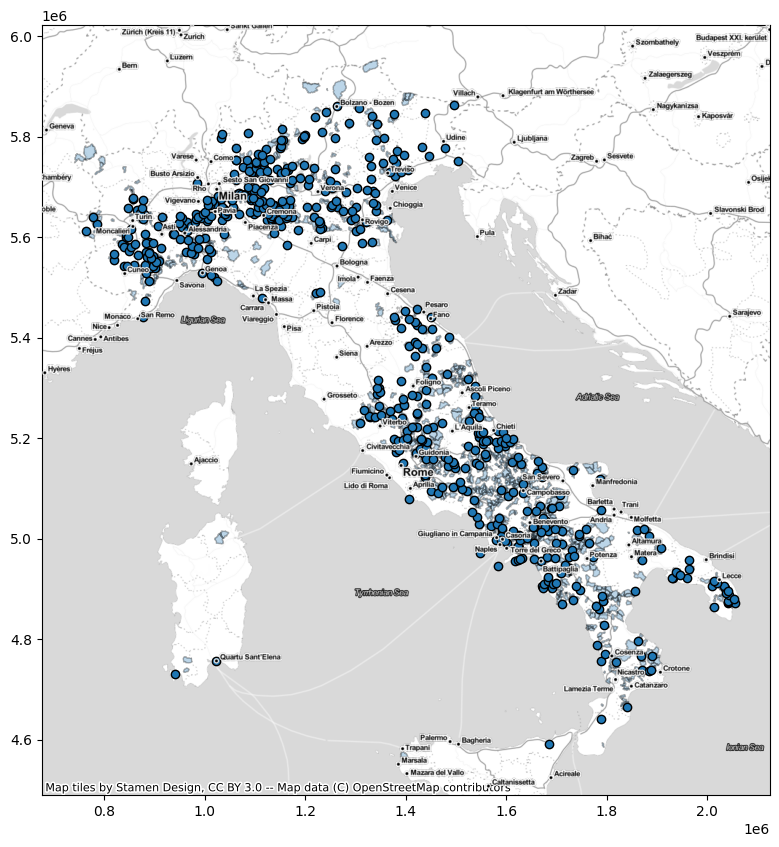

In [250]:
show_map(geocoded_gdf, without_townhall_gdf)

In [251]:
geocoded_gdf.to_file(geocoded_json_file_path, driver="GeoJSON")

In [252]:
#%pip install folium matplotlib mapclassify
geocoded_gdf.explore()

### Compare likely town halls from OSM and Public Data

In [253]:
compare_gdf = merge(
    geocoded_gdf,
    untagged_missing_gdf,
    how="inner",
    left_on="id",
    right_on="id_town"
)
compare_gdf.count()

Unnamed: 0       1
id               1
osm_id           1
osm_type         1
osm_url          1
name             1
CAP              1
Indirizzo        1
geometry_x       1
id_hall          1
osm_id_hall      1
osm_type_hall    1
osm_url_hall     1
name_hall        1
geometry_y       1
index_town       1
id_town          1
osm_id_town      1
osm_type_town    1
osm_url_town     1
name_town        1
dtype: int64

In [254]:
compare_gdf["distance"] = compare_gdf["geometry_x"].distance(compare_gdf["geometry_y"])
compare_gdf.head()

/tmp/ipykernel_4665/2514922110.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  compare_gdf["distance"] = compare_gdf["geometry_x"].distance(compare_gdf["geometry_y"])


,Unnamed: 0,id,osm_id,osm_type,osm_url,name,CAP,Indirizzo,geometry_x,id_hall,...,osm_url_hall,name_hall,geometry_y,index_town,id_town,osm_id_town,osm_type_town,osm_url_town,name_town,distance
0,334,1835,40939,relation,https://www.openstreetmap.org/relation/40939,Sant'Arpino,81030,Piazza Umberto I,POINT (15.37000 40.84423),11,...,https://www.openstreetmap.org/way/672589063,Municipio di Atella di Napoli (1928-46),"LINESTRING (14.26055 40.96097, 14.26056 40.961...",1834,1835,40939,relation,https://www.openstreetmap.org/relation/40939,Sant'Arpino,1.115089


array([[<AxesSubplot: title={'center': 'distance'}>]], dtype=object)

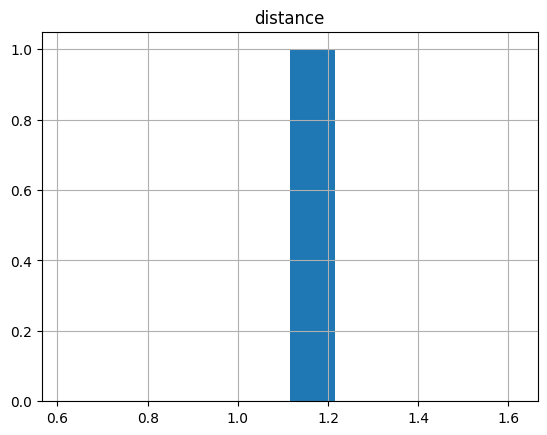

In [255]:
compare_gdf.hist(column="distance")

In [256]:
compare_gdf[compare_gdf["distance"] > 0.1].head()

,Unnamed: 0,id,osm_id,osm_type,osm_url,name,CAP,Indirizzo,geometry_x,id_hall,...,osm_url_hall,name_hall,geometry_y,index_town,id_town,osm_id_town,osm_type_town,osm_url_town,name_town,distance
0,334,1835,40939,relation,https://www.openstreetmap.org/relation/40939,Sant'Arpino,81030,Piazza Umberto I,POINT (15.37000 40.84423),11,...,https://www.openstreetmap.org/way/672589063,Municipio di Atella di Napoli (1928-46),"LINESTRING (14.26055 40.96097, 14.26056 40.961...",1834,1835,40939,relation,https://www.openstreetmap.org/relation/40939,Sant'Arpino,1.115089
